# PyCPT Seasonal

#### Authors: 
Nachiketa Acharya (nachiketa@iri.columbia.edu), Kyle Hall (kjh2171@columbia.edu)

#### Original Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Simon J. Mason (simon@iri.columbia.edu)

#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).


#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.


### Namelist section

In [1]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
work = 'Test4'

########Some folder and file options:
# Where do you want to make the work folder-- this should already exist!!!
workdir = "/Users/kylehall/Projects/PyCPT/Dev/"
# PATH to CPT directory (folder containing CPT.x)
cptdir='/Users/kylehall/CPT/16.5.8/'

########Model (choose one, a subset or all models: 
#CMC1-CanCM3, CMC2-CanCM4,  COLA-RSMAS-CCSM4*, GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*,GFDL-CM2p1-aer04*, NASA-GEOSS2S*, NCEP-CFSv2*)
#The ones with "*" are producing operational forecasts, the others are frozen. 
models=['COLA-RSMAS-CCSM4','GFDL-CM2p5-FLOR-A06']#,'CMC1-CanCM3' 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']

#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE'):
met=['Pearson']#,'Spearman']#,'2AFC','RocAbove','RocBelow', 'RMSE']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC, Chilestations,GPCC)
obs='ENACTS-BD'
station=False

########MOS method (choose between None, PCR, CCA) #Esto es calibracion
MOS='CCA' 


#only used if MOS == 'CCA' or MOS == 'PCR'
xmodes_min = 1
xmodes_max = 8
ymodes_min = 2
ymodes_max = 10
ccamodes_min = 1
ccamodes_max = 5
nmodes = 0 #number of EOF modes to compute

########Predictand (choose between PRCP, RFREQ)
PREDICTAND='PRCP'

########Predictor (choose between GCM's PRCP, VQ, UQ)
#VQ and UQ only works with models=['NCEP-CFSv2']
PREDICTOR='PRCP'

########Target seasons and related parameters
##If more targets, increase the arrays accordingly
#mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mons=['Sep', 'Oct']#, 'Nov', 'Dec']
tgti='1.5'  #S: start for the DL
tgtf='3.5'   #S: end for the DL
#for now, just write the target period (for DL)
#tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
tgts=['Oct-Dec','Nov-Jan']#, 'Dec-Feb', 'Jan-Mar']

tini = 1982
tend = 2009

########Forecast date  
monf=['Sep','Oct']#, 'Nov', 'Dec'] 	# Initialization month 
fyr=2019 	# Forecast year

########Switches: 
force_download = False   #force download of data files, even if they already exist locally --- IF YOU ALREADY HAVE OBS FILES, DOUBLE CHECK WHICH ONES THEY ARE --- True to be safe

# ########Spatial domain for predictor
nla1=35 	# Northernmost latitude
sla1=15 	# Southernmost latitude
wlo1=80 	# Westernmost longitude
elo1=100 	# Easternmost longitude
# Spatial domain for predictand
nla2=28 	# Northernmost latitude
sla2=20 	# Southernmost latitude
wlo2=87 	# Westernmost longitude
elo2=94 	# Easternmost longitude


#NEXTGEN Variables
NGMOS = 'None' #MOS for next gen
file='FCST_xvPr'



### End of namelist section  (do not modify anything below this line)

#### Load Libraries

In [2]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
import platform

setup_directories(work, workdir, force_download, cptdir)


/Users/kylehall/anaconda/envs/pycpt_env37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

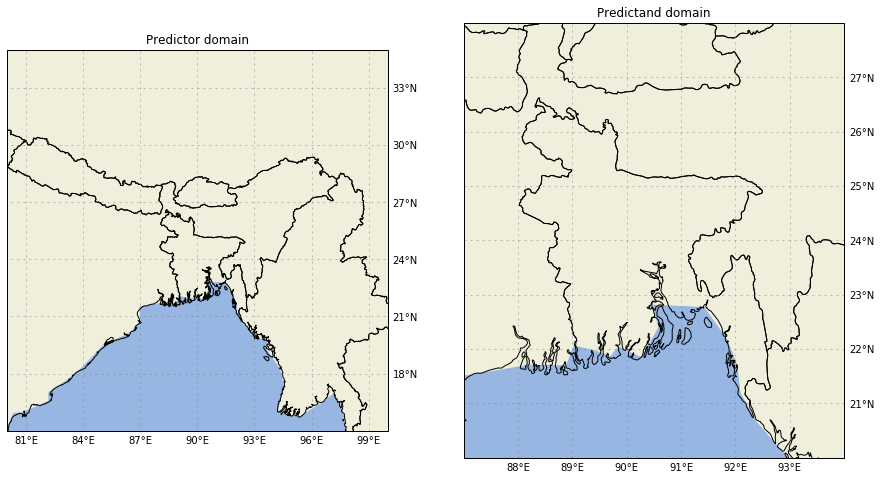

In [3]:
#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

# Download data if necessary, and run CPT

In [4]:

#If downloadling data from several models, this section might take a while to be done
for model in models:
    print('\n\n\n--------Starting process for '+model+'--------')
    for i in range(len(mons)):
        tar, mon = tgts[i], mons[i]
        
        ########Set Up Useful Variables Automatically - tini & tend may change based on tgt
        rainfall_frequency, threshold_pctle, wetday_threshold, obs_source, hdate_last,\
        mpref, L, ntrain, fprefix, nmonths, ndays = setup_params(PREDICTOR,obs,MOS,tini,tend, tgts[i])
            
        #download input files for CPT
        PrepFiles(fprefix, PREDICTAND, threshold_pctle, wlo1, wlo2,elo1, elo2, sla1, sla2, nla1, nla2, tgti, tgtf, mon, monf[i], fyr, os, wetday_threshold, tar, model, obs_source, hdate_last, force_download,station,ndays, nmonths, tini, tend)

        #write CPT input script automatically
        CPTscript(model,PREDICTAND, mon,monf[i], fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS,station, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, tini, tend)

        #run CPT
        RunCPT(cptdir, model, tar, mon)
        




--------Starting process for COLA-RSMAS-CCSM4--------
Predictand is Rainfall Total (mm)
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Sep...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
Executing CPT for COLA-RSMAS-CCSM4 and initialization Sep...
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_COLA-RSMAS-CCSM4_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Oct...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready

## Deterministic Skill Analysis


Pearson


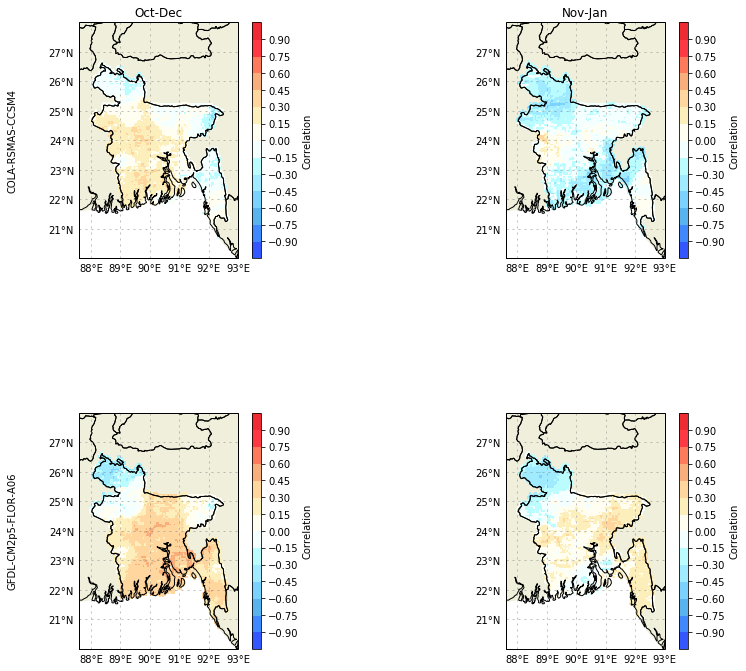

In [5]:
# Skill scores loop
for ime in met:
    pltmap(models,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,mons, obs)   


##### EOF Analysis (only available if MOS=PCR or CCA)

In [6]:
# Skill scores loop
if MOS in ['PCR', 'CCA']:
    for imod in range(nmodes):
        plteofs(models,PREDICTAND,imod,nmodes,wlo1,elo1,sla1,nla1,fprefix,mpref,tgts, mons,tgts,fyr, obs)  

## Multi-model ensemble: NextGen

In [7]:
for i in range(len(mons)):
    tar, mon =tgts[i], mons[i]

    #prepare files for nextgen input using simple mean
    NGensemble(models,fprefix,PREDICTAND,mpref,file,tar,mon,tgti,tgtf,monf[i],fyr)

    #write CPT input script for NextGen
    CPTscript('NextGen',PREDICTAND, mon,monf[i], fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,NGMOS,station, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, tini, tend)

    #run CPT for nextgen
    RunCPT(cptdir, 'NextGen', tar, mon)

Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Sep...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization Sep...
Cross-validated prediction files successfully produced
Executing CPT for NextGen and initialization Sep...
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------



Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Oct...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization Oct...
Cross-validated prediction files successfully produced
Executing CPT for NextGen and initialization Oct...
----------------------------------------------
Calculations for Oct initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Nov-Jan_Oct.txt for errors
----------------------------------------------
----


Pearson


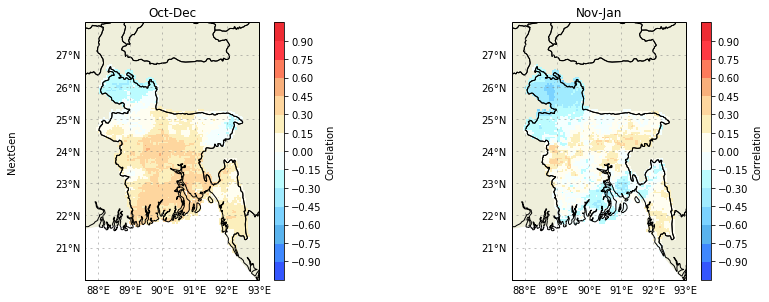

In [8]:
# Skill scores loop
for ime in met:
    pltmap(['NextGen'],PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,mons, obs)   

# Real-Time Forecast

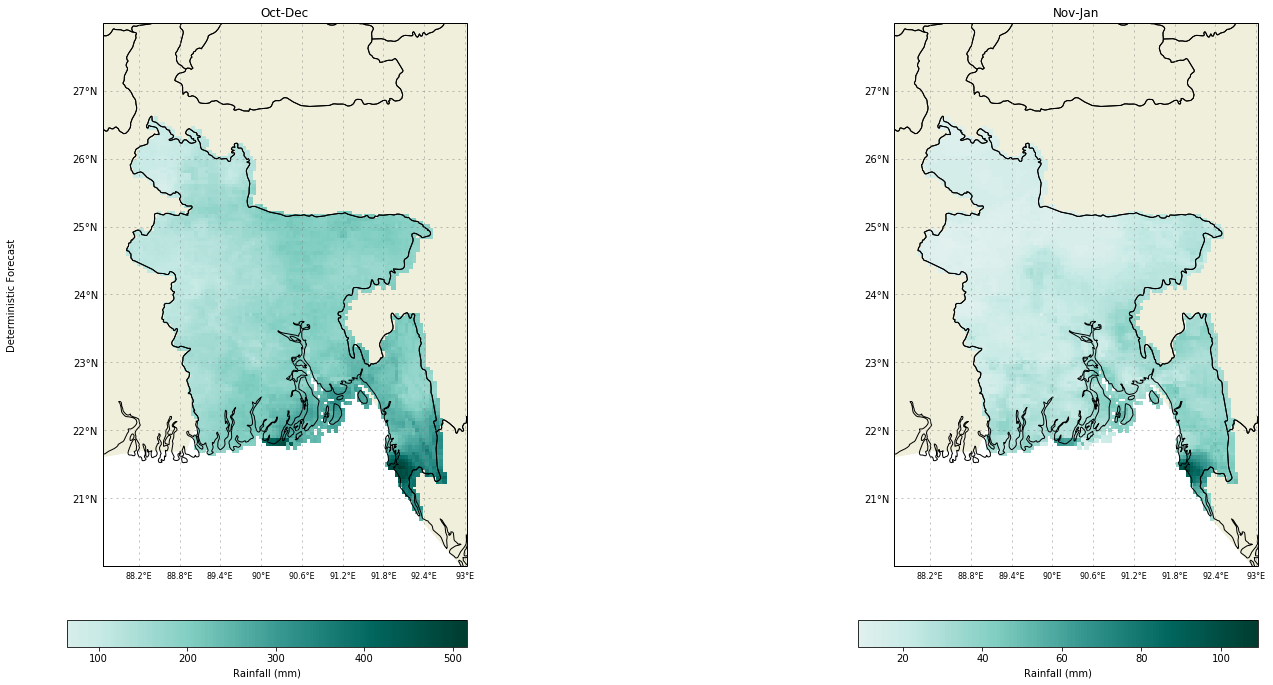

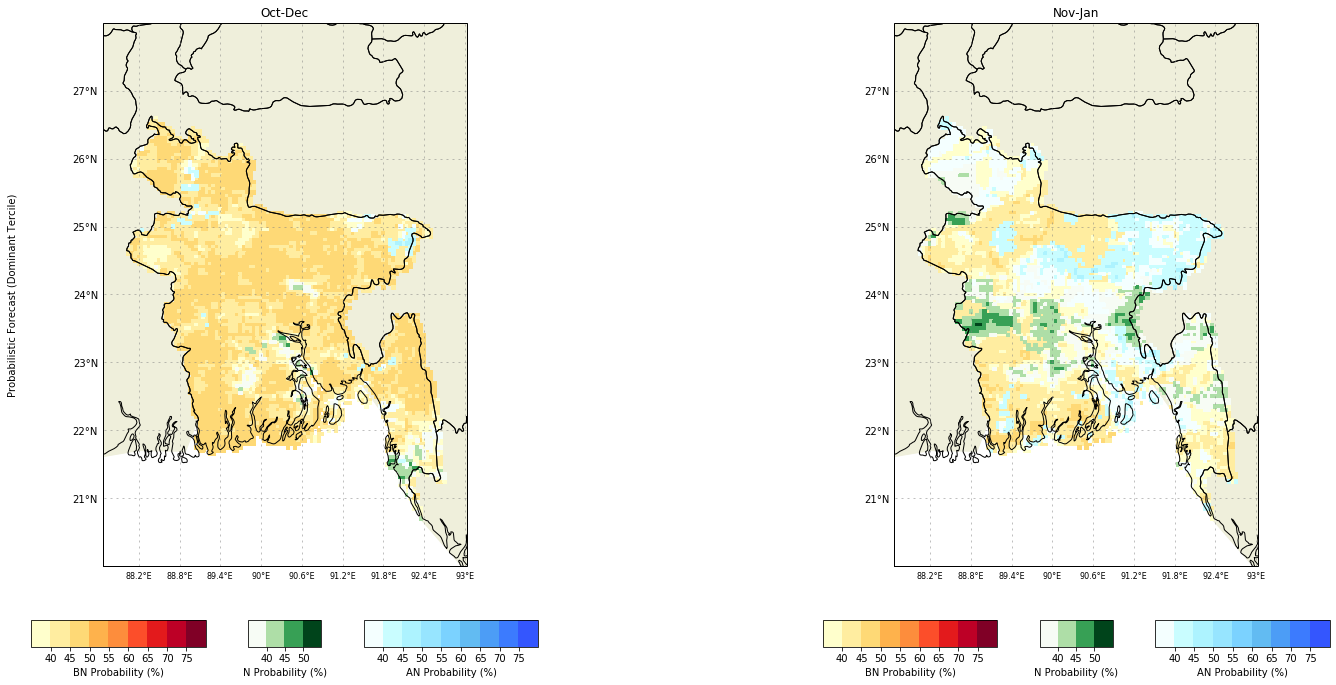

In [9]:
plt_ng_deterministic(['NextGen'], PREDICTAND, wlo2,elo2,sla2,nla2, fprefix, mpref, tgts, mons, fyr)
plt_ng_probabilistic(['NextGen'], PREDICTAND, wlo2,elo2,sla2,nla2, fprefix, mpref, tgts, mons, fyr)

In [10]:
ensemblefiles(['NextGen'],work)

mkdir: ./output/NextGen/: File exists
a 131.txt
a 455.txt
a 501.txt
a NextGen_PRCP_CCAFCST_Obs_Nov-Jan_Oct2019.txt
a NextGen_PRCP_CCAFCST_Obs_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_P_Nov-Jan_Oct2019.txt
a NextGen_PRCP_CCAFCST_P_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_mu_Nov-Jan_Oct2019.txt
a NextGen_PRCP_CCAFCST_mu_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_var_Nov-Jan_Oct2019.txt
a NextGen_PRCP_CCAFCST_var_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_xvPr_Nov-Jan_Oct2019.txt
a NextGen_PRCP_CCAFCST_xvPr_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_z_Nov-Jan_Oct2019.txt
a NextGen_PRCP_CCAFCST_z_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCA_2AFC_Nov-Jan_Oct2019.txt
a NextGen_PRCP_CCA_2AFC_Oct-Dec_Sep2019.txt
tar cvzf ./output/NextGen/Test4_NextGen.tgz *.txt
/Users/kylehall/Projects/PYCPT/Dev/Test4
Compressed file Test4_NextGen.tgz created in output/NextGen/
Now send that file to your contact at the IRI
